# 项目简介
安全帽佩戴检测是计算机视觉在工业安全领域应用的典型场景，本文使用PaddleX进行yolov3_darknet53迁移学习训练，并提供了PaddleX实时视频流预测部署和PaddleHub-Serving服务化部署两种方式。只需数小时，即可完成一个效果良好的安全帽佩戴检测模型全流程部署。

# 环境准备
## 安装工具库

In [ ]:
!pip install ipywidgets

## 解压数据集

In [ ]:
!mkdir MyDataset

In [ ]:
!unzip data/data50329/HelmetDetection.zip -d ./MyDataset

## 切分数据集
### 方案一：使用最新PaddleX的develop分支（不推荐）
该做法步骤如下：
1. 拉取模型库
```bash
# 拉取PaddleX模型库
!git clone https://gitee.com/paddlepaddle/PaddleX.git
```
2. 修改PaddleX/paddlex/tools/dataset_split/voc_split.py源代码（注意：安装PaddleX前必须先修改源代码）
其实就是将VOC数据集默认的`JPEGImages`和`Annotations`修改为与数据集对应的`images`和`annotations`，之所以改源代码而不是目录名，原因在于标注的xml文件都写明了图片存放路径为`images`，权衡之下修改源代码改动更小
```python
import os.path as osp
import random
import xml.etree.ElementTree as ET
from .utils import list_files, is_pic, replace_ext
import paddlex.utils.logging as logging


def split_voc_dataset(dataset_dir, val_percent, test_percent, save_dir):
    if not osp.exists(osp.join(dataset_dir, "images")):
        logging.error("\'images\' is not found in {}!".format(dataset_dir))
    if not osp.exists(osp.join(dataset_dir, "annotations")):
        logging.error("\'annotations\' is not found in {}!".format(
            dataset_dir))

    all_image_files = list_files(osp.join(dataset_dir, "images"))

    image_anno_list = list()
    label_list = list()
    for image_file in all_image_files:
        if not is_pic(image_file):
            continue
        anno_name = replace_ext(image_file, "xml")
        if osp.exists(osp.join(dataset_dir, "annotations", anno_name)):
            image_anno_list.append([image_file, anno_name])
            try:
                tree = ET.parse(
                    osp.join(dataset_dir, "annotations", anno_name))
            except:
                raise Exception("文件{}不是一个良构的xml文件，请检查标注文件".format(
                    osp.join(dataset_dir, "annotations", anno_name)))
            objs = tree.findall("object")
            for i, obj in enumerate(objs):
                cname = obj.find('name').text
                if not cname in label_list:
                    label_list.append(cname)
        else:
            logging.error("The annotation file {} doesn't exist!".format(
                anno_name))

    random.shuffle(image_anno_list)
    image_num = len(image_anno_list)
    val_num = int(image_num * val_percent)
    test_num = int(image_num * test_percent)
    train_num = image_num - val_num - test_num

    train_image_anno_list = image_anno_list[:train_num]
    val_image_anno_list = image_anno_list[train_num:train_num + val_num]
    test_image_anno_list = image_anno_list[train_num + val_num:]

    with open(
            osp.join(save_dir, 'train_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in train_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'val_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in val_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    if len(test_image_anno_list):
        with open(
                osp.join(save_dir, 'test_list.txt'), mode='w',
                encoding='utf-8') as f:
            for x in test_image_anno_list:
                file = osp.join("images", x[0])
                label = osp.join("annotations", x[1])
                f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'labels.txt'), mode='w', encoding='utf-8') as f:
        for l in sorted(label_list):
            f.write('{}\n'.format(l))

    return train_num, val_num, test_num
```
3. 安装PaddleX的develop分支
```bash
# 安装依赖库
!pip uninstall paddlehub -y
!pip install colorama -i http://pypi.doubanio.com/simple/ --trusted-host pypi.doubanio.com
!pip install shapely>=1.7.0 -i http://pypi.doubanio.com/simple/ --trusted-host pypi.doubanio.com
!pip install paddleslim==1.0.1 -i http://pypi.doubanio.com/simple/ --trusted-host pypi.doubanio.com
!pip install paddlehub>=1.6.2 -i http://pypi.doubanio.com/simple/ --trusted-host pypi.doubanio.com
# 安装PaddleX的develop分支
!cd PaddleX && git checkout develop && python setup.py install 
```

安装PaddleX的develop分支后，可直接使用命令行切分数据集，效果如下：

In [ ]:
# !paddlex --split_dataset --format VOC --dataset_dir MyDataset --val_value 0.2 --test_value 0.1

Dataset Split Done.
Train samples: 3500
Eval samples: 1000
Test samples: 500
Split files saved in MyDataset


### 方案二：参考develop分支的voc_split.py重写数据集切分代码
该做法步骤如下：
1. 从pip安装PaddleX
2. 将`voc_split.py`import的方法一一找出，在Notebook中运行
3. 修改voc_split.py切分数据集时对应的文件目录名

In [ ]:
# pip安装PaddleX
!pip install paddlex

In [ ]:
# PaddleX/paddlex/tools/dataset_split/utils.py

# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import os.path as osp
from PIL import Image
import numpy as np
import json


class MyEncoder(json.JSONEncoder):
    # 调整json文件存储形式
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def list_files(dirname):
    """ 列出目录下所有文件（包括所属的一级子目录下文件）

    Args:
        dirname: 目录路径
    """

    def filter_file(f):
        if f.startswith('.'):
            return True
        return False

    all_files = list()
    dirs = list()
    for f in os.listdir(dirname):
        if filter_file(f):
            continue
        if osp.isdir(osp.join(dirname, f)):
            dirs.append(f)
        else:
            all_files.append(f)
    for d in dirs:
        for f in os.listdir(osp.join(dirname, d)):
            if filter_file(f):
                continue
            if osp.isdir(osp.join(dirname, d, f)):
                continue
            all_files.append(osp.join(d, f))
    return all_files


def is_pic(filename):
    """ 判断文件是否为图片格式

    Args:
        filename: 文件路径
    """
    suffixes = {'JPEG', 'jpeg', 'JPG', 'jpg', 'BMP', 'bmp', 'PNG', 'png'}
    suffix = filename.strip().split('.')[-1]
    if suffix not in suffixes:
        return False
    return True


def replace_ext(filename, new_ext):
    """ 替换文件后缀

    Args:
        filename: 文件路径
        new_ext: 需要替换的新的后缀
    """
    items = filename.split(".")
    items[-1] = new_ext
    new_filename = ".".join(items)
    return new_filename


def read_seg_ann(pngfile):
    """ 解析语义分割的标注png图片

    Args:
        pngfile: 包含标注信息的png图片路径
    """
    grt = np.asarray(Image.open(pngfile))
    labels = list(np.unique(grt))
    if 255 in labels:
        labels.remove(255)
    return labels


In [ ]:
# PaddleX/paddlex/utils/logging.py

# copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import time
import os
import sys
import colorama
from colorama import init
import paddlex

init(autoreset=True)
levels = {0: 'ERROR', 1: 'WARNING', 2: 'INFO', 3: 'DEBUG'}


def log(level=2, message="", use_color=False):
    current_time = time.time()
    time_array = time.localtime(current_time)
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time_array)
    if paddlex.log_level >= level:
        if use_color:
            print("\033[1;31;40m{} [{}]\t{}\033[0m".format(
                current_time, levels[level], message).encode("utf-8").decode(
                    "latin1"))
        else:
            print("{} [{}]\t{}".format(current_time, levels[level], message)
                  .encode("utf-8").decode("latin1"))
        sys.stdout.flush()


def debug(message="", use_color=False):
    log(level=3, message=message, use_color=use_color)


def info(message="", use_color=False):
    log(level=2, message=message, use_color=use_color)


def warning(message="", use_color=True):
    log(level=1, message=message, use_color=use_color)


def error(message="", use_color=True, exit=True):
    log(level=0, message=message, use_color=use_color)
    if exit:
        sys.exit(-1)


In [ ]:
# Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os.path as osp
import random
import xml.etree.ElementTree as ET


def split_voc_dataset(dataset_dir, val_percent, test_percent, save_dir):
    # 注意图片目录和标注目录名已全部修改
    if not osp.exists(osp.join(dataset_dir, "images")):
        logging.error("\'images\' is not found in {}!".format(dataset_dir))
    if not osp.exists(osp.join(dataset_dir, "annotations")):
        logging.error("\'annotations\' is not found in {}!".format(
            dataset_dir))

    all_image_files = list_files(osp.join(dataset_dir, "images"))

    image_anno_list = list()
    label_list = list()
    for image_file in all_image_files:
        if not is_pic(image_file):
            continue
        anno_name = replace_ext(image_file, "xml")
        if osp.exists(osp.join(dataset_dir, "annotations", anno_name)):
            image_anno_list.append([image_file, anno_name])
            try:
                tree = ET.parse(
                    osp.join(dataset_dir, "annotations", anno_name))
            except:
                raise Exception("文件{}不是一个良构的xml文件，请检查标注文件".format(
                    osp.join(dataset_dir, "annotations", anno_name)))
            objs = tree.findall("object")
            for i, obj in enumerate(objs):
                cname = obj.find('name').text
                if not cname in label_list:
                    label_list.append(cname)
        else:
            logging.error("The annotation file {} doesn't exist!".format(
                anno_name))

    random.shuffle(image_anno_list)
    image_num = len(image_anno_list)
    val_num = int(image_num * val_percent)
    test_num = int(image_num * test_percent)
    train_num = image_num - val_num - test_num

    train_image_anno_list = image_anno_list[:train_num]
    val_image_anno_list = image_anno_list[train_num:train_num + val_num]
    test_image_anno_list = image_anno_list[train_num + val_num:]

    with open(
            osp.join(save_dir, 'train_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in train_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'val_list.txt'), mode='w',
            encoding='utf-8') as f:
        for x in val_image_anno_list:
            file = osp.join("images", x[0])
            label = osp.join("annotations", x[1])
            f.write('{} {}\n'.format(file, label))
    if len(test_image_anno_list):
        with open(
                osp.join(save_dir, 'test_list.txt'), mode='w',
                encoding='utf-8') as f:
            for x in test_image_anno_list:
                file = osp.join("images", x[0])
                label = osp.join("annotations", x[1])
                f.write('{} {}\n'.format(file, label))
    with open(
            osp.join(save_dir, 'labels.txt'), mode='w', encoding='utf-8') as f:
        for l in sorted(label_list):
            f.write('{}\n'.format(l))

    return train_num, val_num, test_num


if __name__ == "__main__":
    # 切分数据集
    split_voc_dataset('MyDataset', 0.2, 0.1, 'MyDataset')


# 训练yolov3_darknet53迁移学习模型
这里直接使用[官方文档yolov3_darknet53训练代码](https://github.com/PaddlePaddle/PaddleX/blob/develop/tutorials/train/object_detection/yolov3_darknet53.py)，注释非常详细，几乎没有改动。

VisualDL训练过程请查看`output/yolov3_darknet53/vdl_log`目录。

1. loss下降趋势

![file](https://ai-studio-static-online.cdn.bcebos.com/19d0b3f2ef7d4a8f9d4707ce1270b50e7b69d9afbd324c949e06ee7808fbe1c2)

2. 学习率变化

![file](https://ai-studio-static-online.cdn.bcebos.com/da67f4062831452392f50c8b754d340d4fb8b31cc6da47b89094b43d9432de45)

3. 验证集上bbox_map变化

![file](https://ai-studio-static-online.cdn.bcebos.com/9fdde2c046394465a973a2dac23aa22377f914a7cf584637a572bf82bf1b166e)


In [8]:
# 环境变量配置，用于控制是否使用GPU
# 说明文档：https://paddlex.readthedocs.io/zh_CN/develop/appendix/parameters.html#gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from paddlex.det import transforms
import paddlex as pdx

# 定义训练和验证时的transforms
# API说明 https://paddlex.readthedocs.io/zh_CN/develop/apis/transforms/det_transforms.html
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250), transforms.RandomDistort(),
    transforms.RandomExpand(), transforms.RandomCrop(), transforms.Resize(
        target_size=608, interp='RANDOM'), transforms.RandomHorizontalFlip(),
    transforms.Normalize()
])

eval_transforms = transforms.Compose([
    transforms.Resize(
        target_size=608, interp='CUBIC'), transforms.Normalize()
])

# 定义训练和验证所用的数据集
# API说明：https://paddlex.readthedocs.io/zh_CN/develop/apis/datasets.html#paddlex-datasets-vocdetection
train_dataset = pdx.datasets.VOCDetection(
    data_dir='MyDataset',
    file_list='MyDataset/train_list.txt',
    label_list='MyDataset/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='MyDataset',
    file_list='MyDataset/val_list.txt',
    label_list='MyDataset/labels.txt',
    transforms=eval_transforms)

# 初始化模型，并进行训练
# 可使用VisualDL查看训练指标，参考https://paddlex.readthedocs.io/zh_CN/develop/train/visualdl.html
num_classes = len(train_dataset.labels)

# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#paddlex-det-yolov3
model = pdx.det.YOLOv3(num_classes=num_classes, backbone='DarkNet53')

# API说明: https://paddlex.readthedocs.io/zh_CN/develop/apis/models/detection.html#train
# 各参数介绍与调整说明：https://paddlex.readthedocs.io/zh_CN/develop/appendix/parameters.html
model.train(
    num_epochs=270,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    lr_decay_epochs=[210, 240],
    save_dir='output/yolov3_darknet53',
    use_vdl=True)

# Python部署
PaddleX已经集成了基于Python的高性能预测接口，下面演示单张图片和视频流的预测效果。
## 导出预测模型

In [ ]:
!paddlex --export_inference --model_dir=./output/yolov3_darknet53/epoch_220 --save_dir=./inference_model

W0830 11:54:15.850441 10972 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 10.1, Runtime API Version: 9.0
W0830 11:54:15.854879 10972 device_context.cc:260] device: 0, cuDNN Version: 7.3.
2020-08-30 11:54:20 [INFO]	Model[YOLOv3] loaded.
2020-08-30 11:54:21 [INFO]	Model for inference deploy saved in ./inference_model.


### 单张图片预测
选择一张测试集中的图片，查看预测效果

In [ ]:
import paddlex as pdx
predictor = pdx.deploy.Predictor('./inference_model')
result = predictor.predict(image='MyDataset/images/hard_hat_workers1457.png')

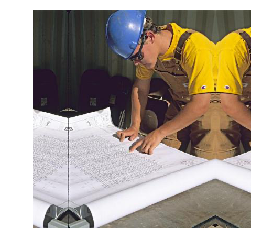

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt # plt 用于显示图片
import numpy as np
import cv2

# 读取原始图片
origin_pic = cv2.imread('MyDataset/images/hard_hat_workers1457.png')
origin_pic = cv2.cvtColor(origin_pic, cv2.COLOR_BGR2RGB)
plt.imshow(origin_pic)
plt.axis('off') # 不显示坐标轴
plt.show()

In [ ]:
result

[{'category_id': 1,
  'bbox': [131.40003967285156,
   2.1436729431152344,
   114.73101806640625,
   107.99861526489258],
  'score': 0.9960896372795105,
  'category': 'helmet'}]

### 视频流预测
在AI Studio中不能演示实时效果，因此采用将预测图片保存再合成视频的形式。同样需要重写`paddlex.det.visualize()`方法

In [23]:
??paddlex.det.visualize

In [1]:
def draw_bbox_mask(image, results, threshold=0.5):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib as mpl
    import matplotlib.figure as mplfigure
    import matplotlib.colors as mplc
    from matplotlib.backends.backend_agg import FigureCanvasAgg

    # refer to  https://github.com/facebookresearch/detectron2/blob/master/detectron2/utils/visualizer.py
    def _change_color_brightness(color, brightness_factor):
        assert brightness_factor >= -1.0 and brightness_factor <= 1.0
        color = mplc.to_rgb(color)
        polygon_color = colorsys.rgb_to_hls(*mplc.to_rgb(color))
        modified_lightness = polygon_color[1] + (brightness_factor *
                                                 polygon_color[1])
        modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
        modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
        modified_color = colorsys.hls_to_rgb(
            polygon_color[0], modified_lightness, polygon_color[2])
        return modified_color

    _SMALL_OBJECT_AREA_THRESH = 1000
    # setup figure
    width, height = image.shape[1], image.shape[0]
    scale = 1
    fig = mplfigure.Figure(frameon=False)
    dpi = fig.get_dpi()
    fig.set_size_inches(
        (width * scale + 1e-2) / dpi,
        (height * scale + 1e-2) / dpi, )
    canvas = FigureCanvasAgg(fig)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.axis("off")
    ax.set_xlim(0.0, width)
    ax.set_ylim(height)
    default_font_size = max(np.sqrt(height * width) // 90, 10 // scale)
    linewidth = max(default_font_size / 4, 1)

    labels = list()
    for dt in np.array(results):
        if dt['category'] not in labels:
            labels.append(dt['category'])
    color_map = get_color_map_list(256)

    keep_results = []
    areas = []
    for dt in np.array(results):
        cname, bbox, score = dt['category'], dt['bbox'], dt['score']
        if score < threshold:
            continue
        keep_results.append(dt)
        areas.append(bbox[2] * bbox[3])
    areas = np.asarray(areas)
    sorted_idxs = np.argsort(-areas).tolist()
    keep_results = [keep_results[k]
                    for k in sorted_idxs] if len(keep_results) > 0 else []

    for dt in np.array(keep_results):
        cname, bbox, score = dt['category'], dt['bbox'], dt['score']
        xmin, ymin, w, h = bbox
        xmax = xmin + w
        ymax = ymin + h

        color = tuple(color_map[labels.index(cname) + 2])
        color = [c / 255. for c in color]
        # draw bbox
        ax.add_patch(
            mpl.patches.Rectangle(
                (xmin, ymin),
                w,
                h,
                fill=False,
                edgecolor=color,
                linewidth=linewidth * scale,
                alpha=0.8,
                linestyle="-", ))

        # draw mask
        if 'mask' in dt:
            mask = dt['mask']
            mask = np.ascontiguousarray(mask)
            res = cv2.findContours(
                mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
            hierarchy = res[-1]
            alpha = 0.5
            if hierarchy is not None:
                has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
                res = res[-2]
                res = [x.flatten() for x in res]
                res = [x for x in res if len(x) >= 6]
                for segment in res:
                    segment = segment.reshape(-1, 2)
                    edge_color = mplc.to_rgb(color) + (1, )
                    polygon = mpl.patches.Polygon(
                        segment,
                        fill=True,
                        facecolor=mplc.to_rgb(color) + (alpha, ),
                        edgecolor=edge_color,
                        linewidth=max(default_font_size // 15 * scale, 1), )
                    ax.add_patch(polygon)

        # draw label
        text_pos = (xmin, ymin)
        horiz_align = "left"
        instance_area = w * h
        if (instance_area < _SMALL_OBJECT_AREA_THRESH * scale or
                h < 40 * scale):
            if ymin >= height - 5:
                text_pos = (xmin, ymin)
            else:
                text_pos = (xmin, ymax)
        height_ratio = h / np.sqrt(height * width)
        font_size = (np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2,
                             2) * 0.5 * default_font_size)
        text = "{} {:.2f}".format(cname, score)
        color = np.maximum(list(mplc.to_rgb(color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))
        color = _change_color_brightness(color, brightness_factor=0.7)
        ax.text(
            text_pos[0],
            text_pos[1],
            text,
            size=font_size * scale,
            family="sans-serif",
            bbox={
                "facecolor": "black",
                "alpha": 0.8,
                "pad": 0.7,
                "edgecolor": "none"
            },
            verticalalignment="top",
            horizontalalignment=horiz_align,
            color=color,
            zorder=10,
            rotation=0, )

    s, (width, height) = canvas.print_to_buffer()
    buffer = np.frombuffer(s, dtype="uint8")

    img_rgba = buffer.reshape(height, width, 4)
    rgb, alpha = np.split(img_rgba, [3], axis=2)

    try:
        import numexpr as ne
        visualized_image = ne.evaluate(
            "image * (1 - alpha / 255.0) + rgb * (alpha / 255.0)")
    except ImportError:
        alpha = alpha.astype("float32") / 255.0
        visualized_image = image * (1 - alpha) + rgb * alpha

    visualized_image = visualized_image.astype("uint8")

    return visualized_image

In [2]:
def get_color_map_list(num_classes):
    """ Returns the color map for visualizing the segmentation mask,
        which can support arbitrary number of classes.
    Args:
        num_classes: Number of classes
    Returns:
        The color map
    """
    color_map = num_classes * [0, 0, 0]
    for i in range(0, num_classes):
        j = 0
        lab = i
        while lab:
            color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
            color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
            color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
            j += 1
            lab >>= 3
    color_map = [color_map[i:i + 3] for i in range(0, len(color_map), 3)]
    return color_map

In [3]:
def visualize(image, result, threshold=0.5, img_num=0,save_dir='./'):
    """
        Visualize bbox and mask results
    """

    if isinstance(image, np.ndarray):
        image_name = str(img_num) + '.jpg'
    else:
        image_name = os.path.split(image)[-1]
        image = cv2.imread(image)

    image = draw_bbox_mask(image, result, threshold=threshold)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        out_path = os.path.join(save_dir, '{}'.format(image_name))
        cv2.imwrite(out_path, image)
        print('The visualized result is saved as {}'.format(out_path))
    else:
        return image

In [4]:
import time
import os
import sys
import colorama
from colorama import init
import paddlex

init(autoreset=True)
levels = {0: 'ERROR', 1: 'WARNING', 2: 'INFO', 3: 'DEBUG'}


def log(level=2, message="", use_color=False):
    current_time = time.time()
    time_array = time.localtime(current_time)
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time_array)
    if paddlex.log_level >= level:
        if use_color:
            print("\033[1;31;40m{} [{}]\t{}\033[0m".format(
                current_time, levels[level], message).encode("utf-8").decode(
                    "latin1"))
        else:
            print("{} [{}]\t{}".format(current_time, levels[level], message)
                  .encode("utf-8").decode("latin1"))
        sys.stdout.flush()


def debug(message="", use_color=False):
    log(level=3, message=message, use_color=use_color)


def info(message="", use_color=False):
    log(level=2, message=message, use_color=use_color)


def warning(message="", use_color=True):
    log(level=1, message=message, use_color=use_color)


def error(message="", use_color=True, exit=True):
    log(level=0, message=message, use_color=use_color)
    if exit:
        sys.exit(-1)


In [24]:
import cv2
import paddlex as pdx
import numpy as np
import colorsys
import os

predictor = pdx.deploy.Predictor('./inference_model')
cap = cv2.VideoCapture('./hatdet.mp4')
i = 1
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        result = predictor.predict(frame)
        print(i)
        vis_img = visualize(frame, result, threshold=0.4, img_num=i, save_dir='hatdet')
        i += 1
        # 本地环境可以实时查看安全帽检测效果
        # cv2.imshow('hatdet', vis_img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

In [ ]:
# 将图片合成视频
!ffmpeg -f image2 -i ./hatdet/%d.jpg -vcodec libx264 -r 30 video.mp4

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [ ]:
import IPython
IPython.display.Video('video.mp4')

# HubServing轻量级服务化部署
**注意：使用此方式部署，需确保自己Python环境中PaddleHub的版本高于1.8.0,因此需要将AI Studio中的Paddlehub升级。**
- [轻量级服务化部署](https://github.com/paddlepaddle/PaddleX/blob/develop/docs/deploy/hub_serving.md)
- [PaddleHub-Serving](https://github.com/PaddlePaddle/PaddleHub/blob/develop/docs/tutorial/serving.md)
## 部署模型准备

部署模型的格式均为目录下包含`__model__`，`__params__`和`model.yml`三个文件，也就是`inference_model`目录下的文件格式。

In [ ]:
!pip install paddlehub -U

## 模型转换

将`PaddleX`的`Inference Model`转换成`PaddleHub`的预训练模型，使用命令`hub convert`即可一键转换，对此命令的说明如下：
|参数	|用途|
| -------- | -------- |
|--model_dir/-m |`PaddleX Inference Model`所在的目录|
|--module_name/-n |生成预训练模型的名称|
|--module_version/-v |生成预训练模型的版本，默认为`1.0.0`|
|--output_dir/-o |生成预训练模型的存放位置，默认为`{module_name}_{timestamp}`|

In [ ]:
!hub convert --model_dir inference_model \
              --module_name hatdet \
              --module_version 1.0 

The converted module is stored in `hatdet_1598885245.2985997`.


## 模型安装

将模型转换得到的`.tar.gz`格式的预训练模型压缩包，在进行部署之前需要先安装到本机，使用命令`hub install`一键安装

In [ ]:
!hub install hatdet_1598885245.2985997/hatdet.tar.gz

## 模型部署

打开终端1，输入`hub serving start -m hatdet`完成安全帽检测模型的一键部署
![file](https://ai-studio-static-online.cdn.bcebos.com/e9bf1bb0bb3d4cd8a9df02d0aac6238f213ac39240d547a692ec2d6499306416)

## 预测结果与后处理效果展示

[[{'bbox': [330.64300537109375, 229.9241943359375, 35.1065673828125, 33.229522705078125], 'category': 'helmet', 'category_id': 1, 'score': 0.9941794276237488}, {'bbox': [168.823974609375, 184.2073211669922, 54.227630615234375, 63.723907470703125], 'category': 'helmet', 'category_id': 1, 'score': 0.9892396330833435}, {'bbox': [367.8026123046875, 238.3224639892578, 46.005615234375, 45.48057556152344], 'category': 'helmet', 'category_id': 1, 'score': 0.9855232238769531}, {'bbox': [269.3492736816406, 220.7162322998047, 12.42694091796875, 15.184814453125], 'category': 'helmet', 'category_id': 1, 'score': 0.7675696015357971}, {'bbox': [247.13021850585938, 215.6059112548828, 13.21417236328125, 16.321746826171875], 'category': 'helmet', 'category_id': 1, 'score': 0.5700928568840027}, {'bbox': [232.14540100097656, 250.86013793945312, 10.022308349609375, 11.1153564453125], 'category': 'helmet', 'category_id': 1, 'score': 0.14765863120555878}, {'bbox': [362.0443420410156, 397.7749328613281, 52.13

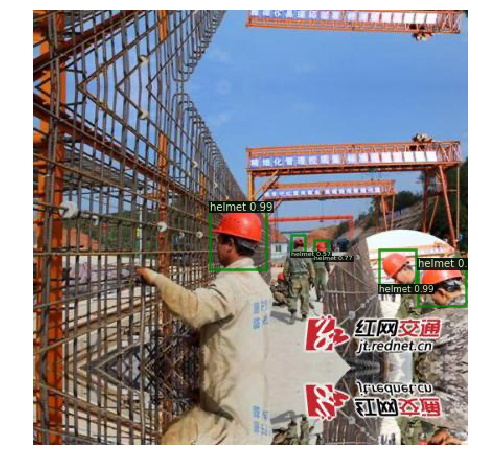

In [38]:
# coding: utf8
%matplotlib inline
import requests
import json
import cv2
import base64
import numpy as np
import colorsys
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12,8))

def cv2_to_base64(image):
    data = cv2.imencode('.png', image)[1]
    return base64.b64encode(data.tostring()).decode('utf8')


if __name__ == '__main__':
    # 获取图片的base64编码格式
    img1 = cv2_to_base64(cv2.imread("MyDataset/images/hard_hat_workers1957.png"))
    img2 = cv2_to_base64(cv2.imread("MyDataset/images/hard_hat_workers1457.png"))
    data = {'images': [img1, img2]}
    # data = {'images': [img1]}
    # 指定content-type
    headers = {"Content-type": "application/json"}
    # 发送HTTP请求
    url = "http://127.0.0.1:8866/predict/hatdet"
    r = requests.post(url=url, headers=headers, data=json.dumps(data))

    # 打印预测结果，注意，r.json()["results"]本身就是一个数组，要取到对应图片的预测结果，需指定元素位置，如r.json()["results"][0]
    print(r.json()["results"])
    # 使用重写的visualize()方法完成预测结果后处理
    # 显示第一张图片的预测效果
    image = visualize(cv2.imread('MyDataset/images/hard_hat_workers1957.png'),r.json()["results"][0], save_dir=None)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off') # 不显示坐标轴
    plt.show()